In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
sns.set_style("darkgrid")

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# deep Q-learning

### Loss

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y_t - Q(s,a,\theta))^2]$



$y = R_{t+1} + \max_a Q(s+1,a,\theta)$

In [2]:
env = gym.make('LunarLander-v2')

In [3]:
class Agent:
    def __init__(self, env):
        self.env = env
    def act(self, state):
        pass
    def train(self, next_state, reward, done): 
        pass

In [4]:
class AgentRandom(Agent):
    def act(self, state):
        return self.env.action_space.sample()

In [5]:
class RunAgentEnv:
    def __init__(self, agent, env, nb_step):
        self.agent = agent
        self.env = env
        self.nb_step = nb_step
        self.rewards = np.zeros(nb_step)
        self.cum_reward_per_episode = [[]]
        self.actions = np.zeros(nb_step)
    def run_experiment(self, is_train=True):
        state = self.env.reset()
        for i in range(self.nb_step):
            action = self.agent.act(state)
            state, reward, done, info = self.env.step(action)
            if is_train == True:
                self.agent.train(state, reward, done)
            if done is True:
                state = self.env.reset()
                print(sum(self.cum_reward_per_episode[-1]))
                self.cum_reward_per_episode.append([])
                
            self.actions[i] = action
            self.rewards[i] = reward
            self.cum_reward_per_episode[-1].append(reward)
        episode_rewards = [sum(ep) for ep in run.cum_reward_per_episode]
        return self.rewards, episode_rewards

In [6]:
agent_rand = AgentRandom(env)

In [7]:
run = RunAgentEnv(agent_rand, env, 50000)

In [8]:
rewards, ep_rewards = run.run_experiment()

-95.28515691961384
-95.66776000969298
-292.5671200665122
-170.34675398914703
-84.02413267133477
-125.25416006665998
-85.48366929486906
-342.84744798779803
-246.72982482219
-501.06626625392136
-97.75107217400927
-121.01984332598951
-167.62109413801238
-129.19284247745813
-403.44427111192346
-89.49052298722198
-148.95418480455754
-98.05577373692209
-107.6205323817301
-160.97700913799378
-142.44226992630888
55.705985409875865
-351.934225750551
-56.63272540224176
-99.50446511714213
-389.07915356657327
-89.842623641076
-324.3886087950256
-126.57814084908296
-123.06830209902398
-315.4530180016893
-197.0093446801675
-161.08420483313256
-195.69134608286544
-187.4016454832456
-91.53686110599494
-188.6244056337402
-62.06329022248832
-360.5524429398349
-220.08233627158873
-105.93587598078221
-180.51496891441622
-235.14715899929368
-255.949153780078
-211.24826808323917
-343.52601129767095
-168.81988061971973
-126.88049903900048
-72.73226598372334
-336.5893698726175
-42.42495742908157
-306.92671582

-323.94237204345154
-403.89997583348116
-124.2289279416561
-222.35068043725082
-133.30415823805413
-96.06349376454794
-316.9061840518158
-158.6151413301517
-279.6976087793829
-138.22911439682957
-102.38722292623032
-420.7852749889654
-113.26981473682149
-189.78023311510998
-211.179281523453
-99.38055172975558
-66.65620744493502
-405.78114654426116
-129.96060125742943
-183.1845055690443
-296.7345197732212
-171.4718563595661
-67.54588419425087
-56.07978771542122
-475.97454223405856
-115.01533323202602
-383.56427414855796
-90.23709347165398
-113.73341474336756
-105.48020842694619
-211.54373780691483
-229.09913744604486
-230.7137594950041
-88.31690452145965
-88.67061073290867
-254.74946514674022
-175.32821877557845
-134.16141329595342
-244.2409631249601
-84.507903681591
-115.105446849315
-114.18159104179978
-193.54341278593265
-242.29770523261763
-268.7629972708058
-253.59202662234793
-237.28246952987024
-196.80219353650025
-93.02467317144817
-178.04549386399057
-84.18626436639855
-87.3618

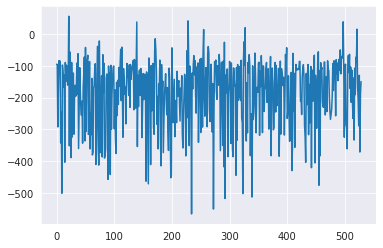

In [9]:
plt.plot(ep_rewards)

In [11]:
class AgentDeepQEpsilon(Agent):
    def __init__(self, env, eps = 0.01, compiled_model = None, load_model_path = None):
        super(AgentDeepQEpsilon2, self).__init__(env)
        self.gamma = 0.99    # discount rate
        self.eps = eps
        self.action_shape = env.action_space.n
        self.state_shape = env.observation_space.shape[0]
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.state = None
        self.action = None
        self.predicted_Q = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_shape,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_shape, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse')
        return model
    
    def save_model(self, path):
        self.model.save(path)
    
    def act(self, state):
        #_ = np.zeros(self.state_shape)
        #_[state] = 1
        #state = _
        self.state = state
        self.predicted_Q = self.model.predict(state.reshape(1,-1))[0]
        if np.random.rand() < self.eps:
            self.action = np.random.randint(self.action_shape)
            return self.action
        self.action = np.argmax(self.predicted_Q) 
        return self.action
    
    def train(self, next_state, reward, done):
        #_ = np.zeros(self.state_shape)
        #_[next_state] = 1
        #next_state = _
        predicted_Q_next_state = self.model.predict(next_state.reshape(1,-1))[0]
        target = self.predicted_Q
        if done is True:
            target[self.action] = reward
        else:
            target[self.action] = reward + self.gamma * max(predicted_Q_next_state)
        self.model.fit(self.state.reshape(1,-1), target.reshape(1,-1), batch_size=1, verbose=0, shuffle=False)

In [13]:
agent_deepQ_epsilon = AgentDeepQEpsilon(env)

In [14]:
run = RunAgentEnv(agent_deepQ_epsilon, env, 50000)

In [15]:
#agent_deepQ_epsilon.save_model('../src/models/test')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../src/models/test/assets


In [17]:
rewards, ep_rewards = run.run_experiment()

-358.31249350286777
-374.93821142045135
-271.877250280702
-216.64706331226154
-344.23843115838713
-337.87183541927135
-231.74584029815378
-314.6246463546477
-310.2484711918876
-159.55288778093825
-513.4102978090567
-170.89663366369203
-169.80021616033267
-135.22301093550956
-137.15232227778696
-214.80890396112423
-265.40250961178145
-566.6384807582682
-334.4569326975165
-457.1302655410932
-1350.1940593943596
-464.09917557552524
-502.9743615245963
-167.07899468862772
-157.0306081027866
-108.15902551495648
-136.82215386528173
5.271923441887253
28.19463944514621
-148.61757439379875
-141.25509861109848
-132.45100501418244
-178.06840520043468
19.915409382678277
-112.69051769648274
-148.51400757182938
-101.3556225971935
-137.1782005375372
-117.4116251767667
-110.68743666832707
-146.86689870727372
-118.04003598112695
-0.49431500393275485
-119.54888868375366
-130.26193803800166
-91.15846429287654
-133.57544671175913
-51.349881603526626
-135.83177254714136
-106.69184426891289
-125.6693213711235

-130.80472954735805
-162.70275969937558
-141.40567784686388
-110.55999901878414
-153.55715844979096
-167.37079189532832
-170.9216323307373
-107.74961851646304
-158.1111398918718
-113.15958369318474
-117.93987466463884
-111.86848158009971
-149.44042799107604
-123.33132058687207
-122.31948269644684
-150.9739580722831
-105.63229635754266
-140.52090259758512
-99.42866320153286
-121.13723826059663
-111.21939062808022
-149.71472338267208
-113.03732688475802
-130.10303386779364
-119.63986931723733
-127.19840284663039
-148.55346638224626
-155.90218398663248
-110.90880580676017
-151.26925876706804
-160.8385000034063
-327.96966328124677
-93.33573855564583
-140.83943407619103
-129.88992687358146
-157.57839204998135
-273.3572791007187
-191.76445415332773
-110.18947426484888
-198.78274840713334
-150.2793442051706
-82.5200217381987
-127.16234155075722
-126.81620834262299
-119.541119412764
-123.86511985912242
-146.979254126195
-110.27240821571203
-137.26096462598994
-244.323147512391
-525.05059890069

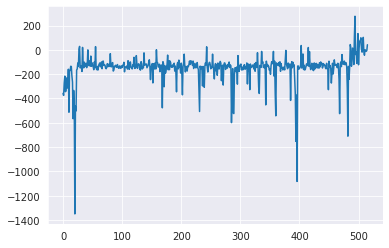

In [18]:
plt.plot(ep_rewards)

In [3]:
model = load_model('../src/models/test')